In [12]:
import requests
from IPython.core.display import HTML
# HTML(f"""
# <style>
# @import "https://cdn.jsdelivr.net/npm/bulma@0.9.4/css/bulma.min.css";
# </style>
# """)

# PCA for shape generation

**Mandatory assignment 2**
This is the second mandatory assignment, to be submitted on LearnIT as a Jupyter Notebook containing your implementation and notes by the deadline specified on [LearnIT](https://learnit.itu.dk/)
. Details on the submission process can be found [here](https://iml.itu.dk/01-about_the_course/01-AboutTheCourse.html)
.
In this assignment, PCA will be applied to generate face shapes. The objective is to explore the relationship between points in the latent space and their corresponding representations in the data space.

<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">


<article class="message">
    <div class="message-body">
        <strong>Overview of mandatory tasks</strong>
        <ul style="list-style: none;">
            <li>
            <a href="#prep">Task 1: Data inspection</a>
            </li>
            <li>
            <a href="#get_pca">Task 2: Get principal compontents</a>
            </li>
            <li>
            <a href="#gen">Task 3: Base face</a>
            </li>
            <li>
            <a href="#gen_reflect">Task 4: Base face reflections </a>
            </li>
            <li>
            <a href="#c">Task 5: Investigate variations in latent space</a>
            </li>
            <li>
            <a href="#interpolate">Task 6: Interpolation between two faces</a>
            </li>
            <li>
            <a href="#reflect">Task 7: Reflection</a>
            </li>
            <li>
            <a href="#correlation_eigen">Task 8: Eigenvalues and eigenvectors of correlat…</a>
            </li>
            <li>
            <a href="#Dimensionality_red">Task 9: Out of distribution generation</a>
            </li>
        </ul>
    </div>
</article>



</div>


**Important**
Solve the in-class exercise about PCA **before starting on this assignment**. You are of course welcome to ask about both the in-class exercise and the assignment. 

## Data
The dataset used for the assigment consist of 120 landmarks (2D points) of faces (data space). A face consists of 73 (x,y)-coordinate pairs, i.e. 146 featues in total.

---
**Task 1 (easy): Data inspection👩‍💻**
1. Run the cell below to load libraries, the data and to  visualize the first 6 sample face shapes.


---

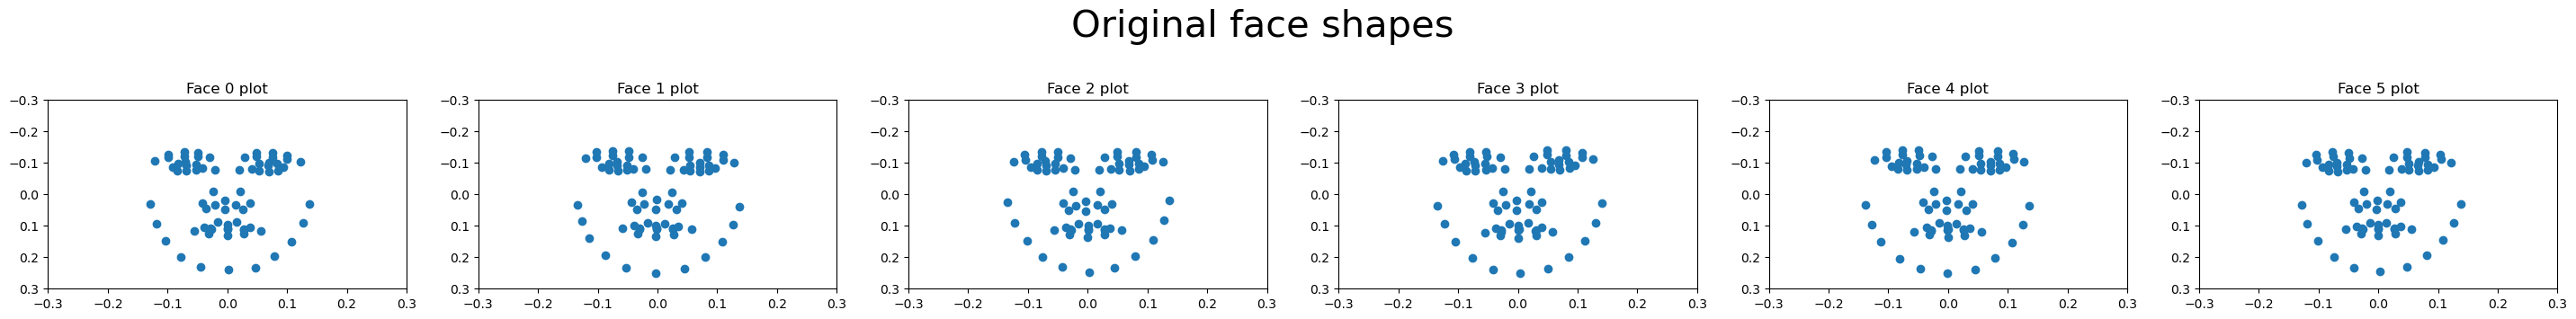

In [13]:
## Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from pca_utils import *
import os
from glob import glob

path = './db/'
shapes, _ = face_shape_data(path)

plot_many_faces(shapes[:6],"Original face shapes");

## PCA implementation
The following tasks are about using the implementation of PCA from the in-class exercise on the face shape dataset. 

---
**Task 2 (easy): Get principal compontents👩‍💻**
1. Complete the `get_principal_components`
 function so that it returns all principal components `comp`
, eigenvalues `val`
 and mean vector `mu`
, given the dataset `shapes`
.
2. Use the `get_principal_components`
 function to calculate the principal components (`comp`
) for the face dataset.
3. How many components are needed to retain $50\%$, $60\%$, $80\%$, $95\%$ of the total variation?
4. Set $k=5$ components. How much of the total variance is retained?
5. Implement the function `transform_to_latent_space`
  according to the comments in the cell below using  $\mathbf{a} = \mathbf{\Phi_k}^\top(\mathbf{x}-\mathbf{\mu})$ .
6. Implement the function `transform_from_latent_space`
  according to the comments in the cell below using $x  = \mathbf{\Phi_k} \mathbf{a} + \mathbf{\mu}$ . 
7. Run the cell below to map $6$ face shapes to the latent space and back to the original data space. The `plot_many_faces`
 function is used to display both the original and the restored face shapes.
8. Visually inspect the figures and describe the reconstruction error.


---

Total variance: 0.008592833338490985
Components needed for each threshold: {'50%': 2, '60%': 2, '80%': 4, '95%': 8}
Variance retained with 5 components: 0.8742165232463094


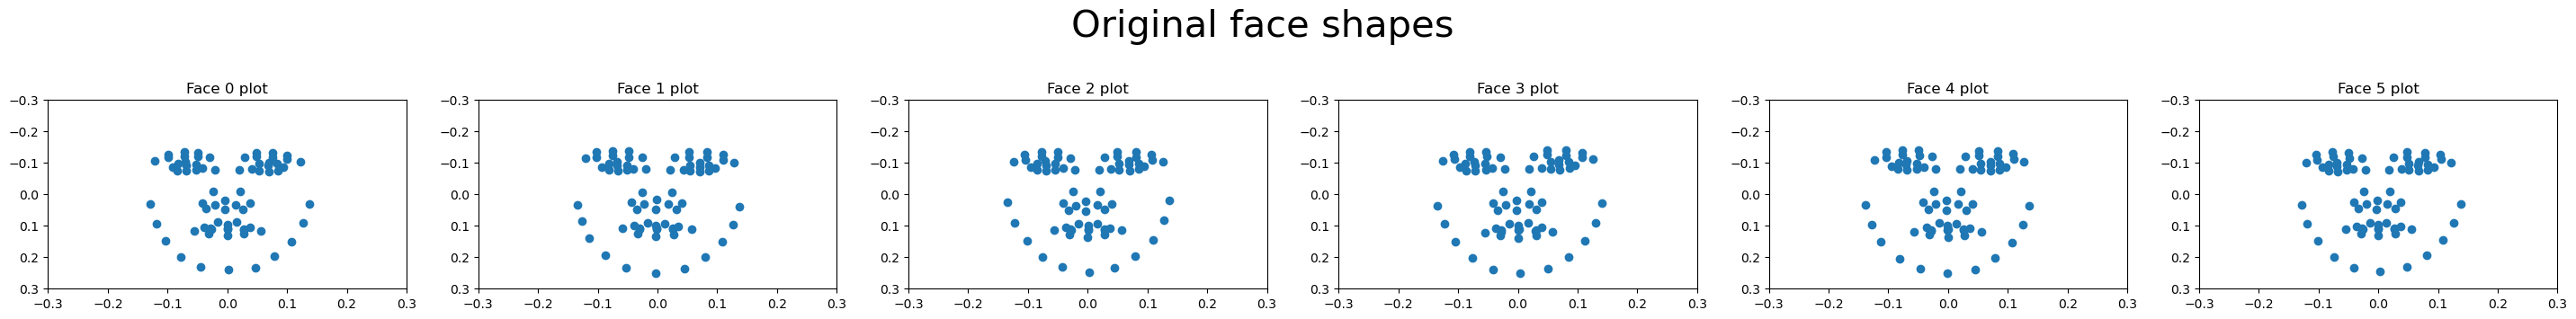

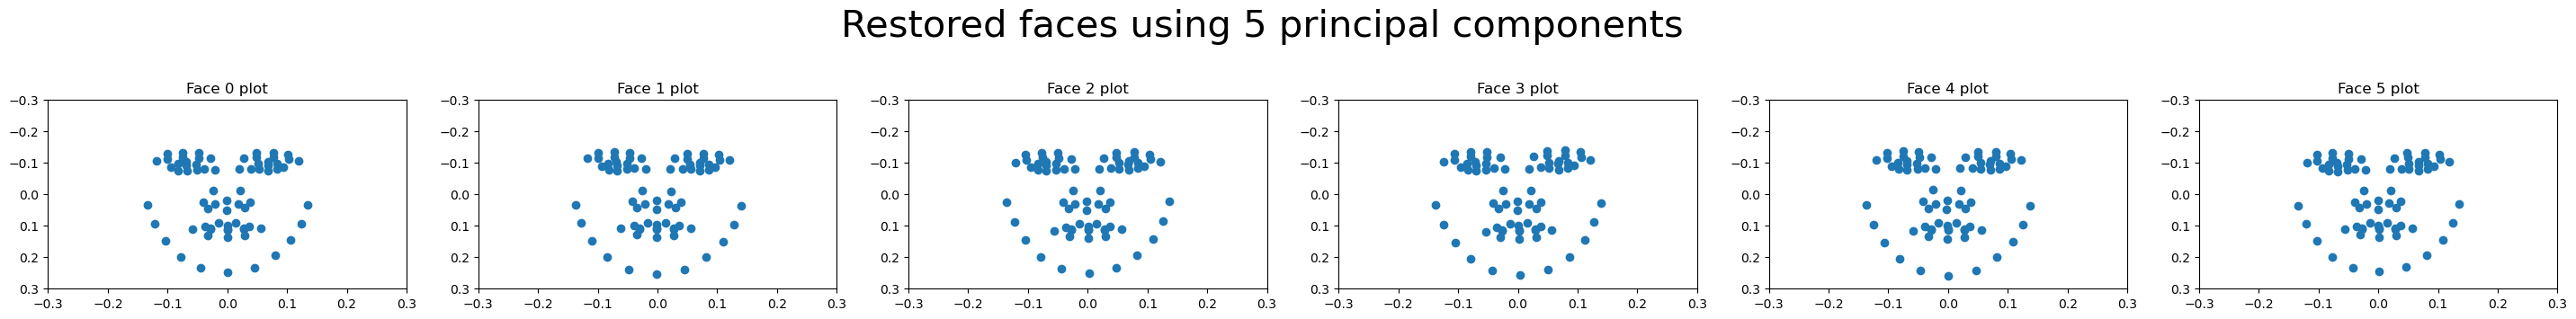

In [14]:
# 1
def get_principal_components(X):
    """Calculates principle components for X.

    Args:
        X: The dataset. An NxD array were N are the number of samples and D are
        the number of features.

    Returns:
        Tuple (components, eigenvalues, mu) where components is a DxD matrix of
        principle components, eigenvalues is a D-element vector of
        corresponding eigenvalues, and mu is a D-element array containing the mean
        vector.
    """
    mean = np.mean(X, axis=0)
    covariance_matrix = np.cov(X - mean, rowvar=False)

    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    return eigenvectors, eigenvalues, mean


# 2, 3 and 4
# Get the principal components for the dataset and transform the faces to feature space.
comp, val, mu = get_principal_components(shapes)

# write code for finding the cumulative proportional variance here
total_variance = np.sum(val)
print("Total variance:", total_variance)
individual_variance_proportion = val / total_variance
cumulative_variance_proportion = np.cumsum(individual_variance_proportion)

thresholds = [0.50, 0.60, 0.80, 0.95]
components_needed = {}

for threshold in thresholds:
    num_components = np.argmax(cumulative_variance_proportion >= threshold) + 1
    components_needed[f"{int(threshold * 100)}%"] = int(num_components)

# Exercise 3
print("Components needed for each threshold:", components_needed)


# Exercise 4
# selecting 5 components 
n_components = 5
variance_retained = cumulative_variance_proportion[n_components - 1]
print(f"Variance retained with {n_components} components:", variance_retained)

# 5
def transform_to_latent_space(X, principle_components, mu):
    """Transforms X to an k-dimensional space where k is the number of
    principle_components.

    Args:
        X: The dataset. An NxD array were N are the number of samples and D are
        the number of features.
        principle_components: An Dxk matrix containing the principle
        components.
        mu: A D-element array containing the mean vector.

    Returns:
        A Nxk array describing the transformed data.
    """
    X_centered = X - mu
    return X_centered @ principle_components


    
# 6  
def transform_from_latent_space(v, principle_components, mu):
    """Reverses the dimensionality reduction of v, a Nxk matrix where
    k is the number of principle components. The result is a NxM matrix.

    Args:
        v: The transformed dataset with size Nxk.
        principle_components: An Dxk matrix containing the principle
        components.
        mu: A Mx1 matrix containing the mean vector.

    Returns:
        An NxD array reconstruction of the original feature vectors X.
    """
    X_reconstructed = v @ principle_components.T
    return X_reconstructed + mu

    
# 7     
used = comp[:, :n_components]

# transforming and reconstructing the 6 first faces in the dataset
plot_many_faces(shapes[:6],"Original face shapes")
transformed_a_b = transform_to_latent_space(shapes[:6], used, mu)
restored = transform_from_latent_space(transformed_a_b, used, mu)
plot_many_faces(restored,"Restored faces using 5 principal components")

## Using PCA for shape generation
The principal components can be used to generate new samples $\mathbf{x}$ in data space by transforming a point in latent space according to 
$$\mathbf{x} = \Phi_{k} a + \mu$$
 where $\Phi_{k}$ is the matrix of k eigenvectors, $\mathbf{a}\in\mathbb{R}^{k}$ is a vector in latent space, and $\mu\in\mathbb{R}^{D}$ is the mean vector of the original data features in  the data space.

$$

{\Phi_k} = \begin{bmatrix} | & | & & | \\ {v}_1 & {v}_2 & \cdots & {v}_k \\ | & | & & | \end{bmatrix}

$$
The variance of the data in a given direction can be used to constrain the values of the elements of the vector $\mathbf{a}$ in latent space, assuming that the data follows a (multivariate) normal distribution. In a multivariate normal distribution each direction $v_i$ is also normally distributed. Each element $a_i$ can be constrained to be within the observed variance in direction $v_i$. The variance $\sigma^2$ in the direction of $v_i$ is given by the eigenvalue $\lambda_i$, so the standard deviation is  $\sigma_i = \sqrt{\lambda_i}$.
In a 1D normal distribution (with mean $\mu$ and standard deviation $\sigma$), the area under the Gaussian curve between $\pm 3\sigma$ contains $99.7\%$ of the data (see [Figure 1](#normal) ). Thus, constraining each element $a_i$ to the interval $[-3\sigma_i, 3\sigma_i]$ will cover $99.7\%$ of the variance in the direction of $v_i$. 
<div class="has-text-centered">
<figure class="image is-inline-block" id="normal">

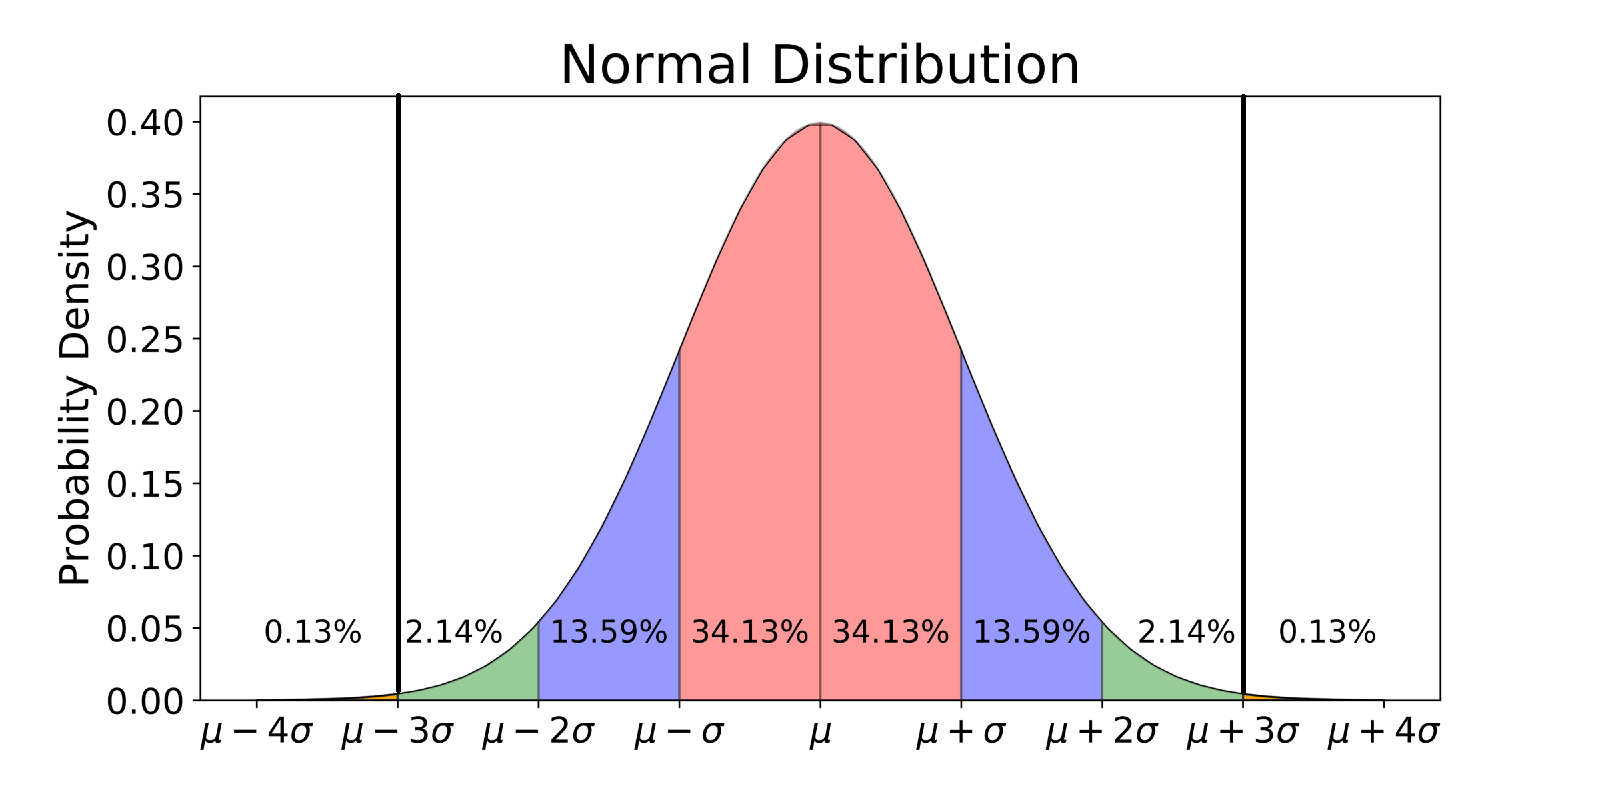

<figcaption class="figure-caption has-text-centered">Figure 1: Illustration of a normal distribution. The vertical lines mark the region covering $99.7\%$ of the variance. The shaded regions indicate the
area of the distribution covered by 1, 2, 3, and 4, standard deviations
($\sigma$) respectively.
</figcaption>
</figure>
</div>

---
**Task 3 (medium): Base face👩‍💻**
1. **Generate vectors:** run the cell below to create the zero vector in latent space, i.e. $\mathbf{a} = [0, 0, \dots, 0]\in\mathbb{R}^5$.
2. **Shape generation:** use $\mathbf{x} = \mathbf{\Phi} \mathbf{a} + \mathbf{\mu}$ to generate a face (vector in real space) from the vector $\mathbf{a}$. Use the `plot_face`
 function to visualise the generated face.
3. Change the elements of $\mathbf{a}$ to the values below, where $\lambda_i$ is the i-th eigenvalue and plot the resulting shapes for each modification:    - $\mathbf{a} = [\lambda_1,0, 0, 0, 0]$ $\in\mathbb{R}^5$? 
    - $\mathbf{a} = [0,-3\lambda_2, 0, 0, 0]$ $\in\mathbb{R}^5$?




---

In [15]:
a = np.array([0,0,0,0,0])

# Tale om hvorfor er min forkert



---
**Task 4 (medium): Base face reflections 💡**
1. Use $\mathbf{x} = \Phi_{k} a + \mu$ to explain what the vector $a \in R^5$ represents if     - $\mathbf{a}= [0,0,0,0,0]$?
    - $\mathbf{a} = [\lambda_1,0, 0, 0, 0]$? 
    - $\mathbf{a} = [0,-3\lambda_2, 0, 0, 0]$?


2. Describe what face is generated and why.


---

In [16]:
# Base face (a=[0,0,0,0,0]): Represents the mean face shape.
# Variation with a=[λ1,0,0,0,0]: Captures variation along the first principal component, typically the most dominant feature change in the dataset.
# Variation with a=[0,-3λ2,0,0,0]: Captures variation along the second principal component, representing another significant axis of shape variation.

## Investigating principal components
The following tasks are about investigating properties of principal components.

---
**Task 5 (medium): Investigate variations in latent space👩‍💻**
1. **Varying the 1st component:** Let $\mathbf{a} \in \mathbb{R^5}$ be a vector in the latent space. Generate 5 different vectors where only the first element, $a_1$, varies, while the remaining elements, $a_2, a_3, a_4, a_5$, are set to 0. Use `np.linspace`
 to generate 5 evenly spaced values for $a_1$ in the interval $[-3\sigma_1, 3\sigma_1]$. For each value of $a_1$, generate a corresponding face and display all 5 faces in a plot. 

2. **More components:** Do the same for each of the remaining four components, i.e. $a_2$-$a_5$ leaving the others as 0. 

3. **Component analysis:** Describe how each principal component changes the face shape (for example, the first component may change the length of the face). 



---

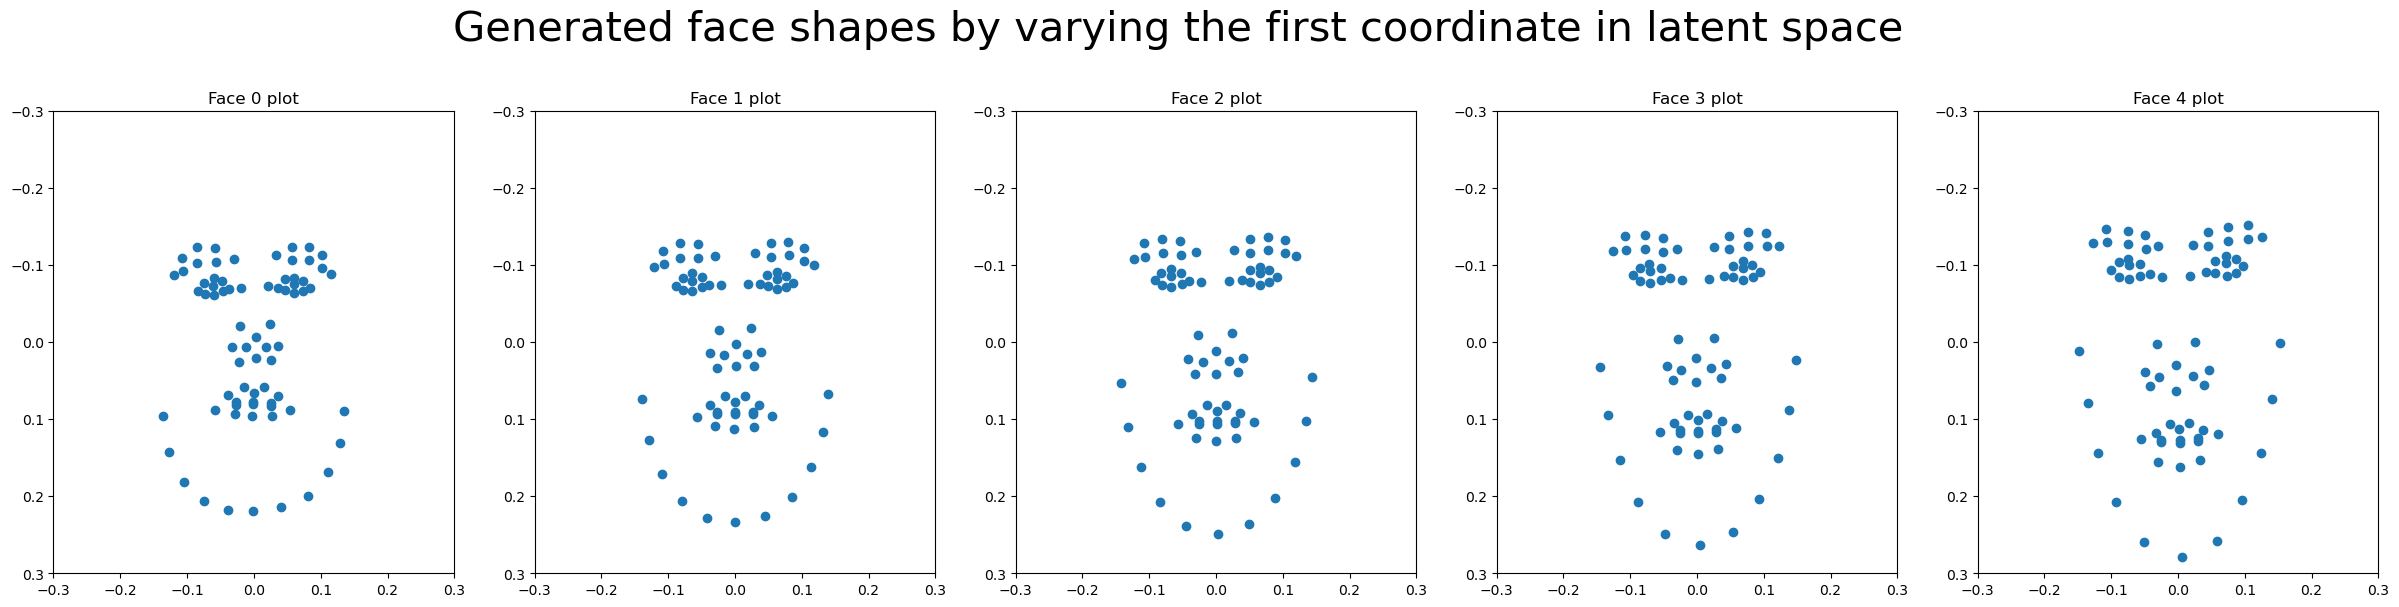

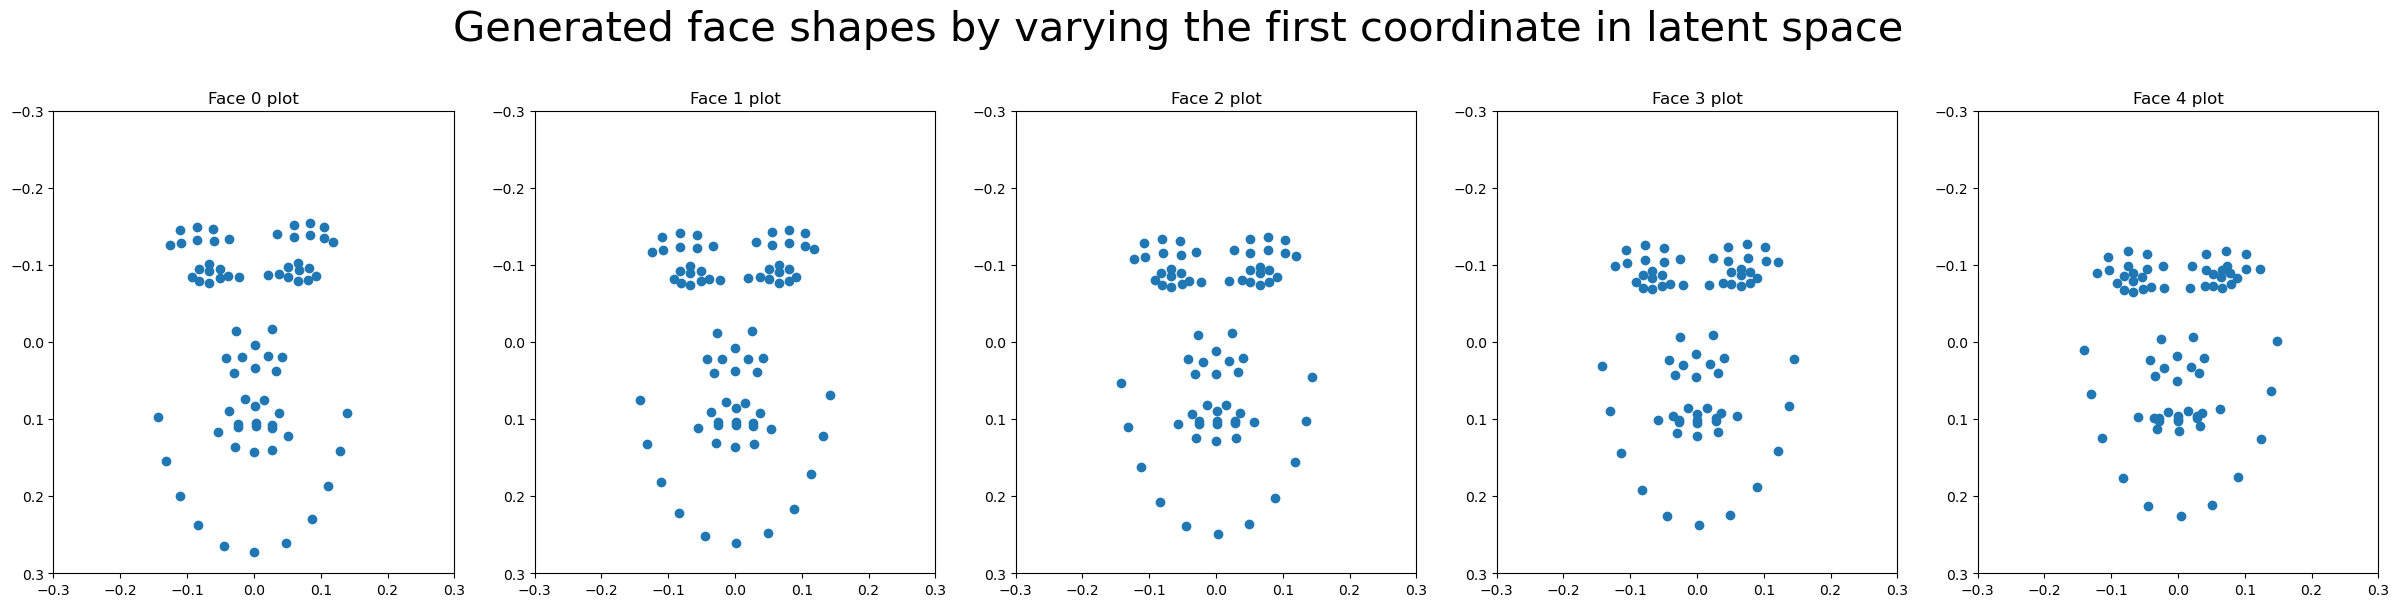

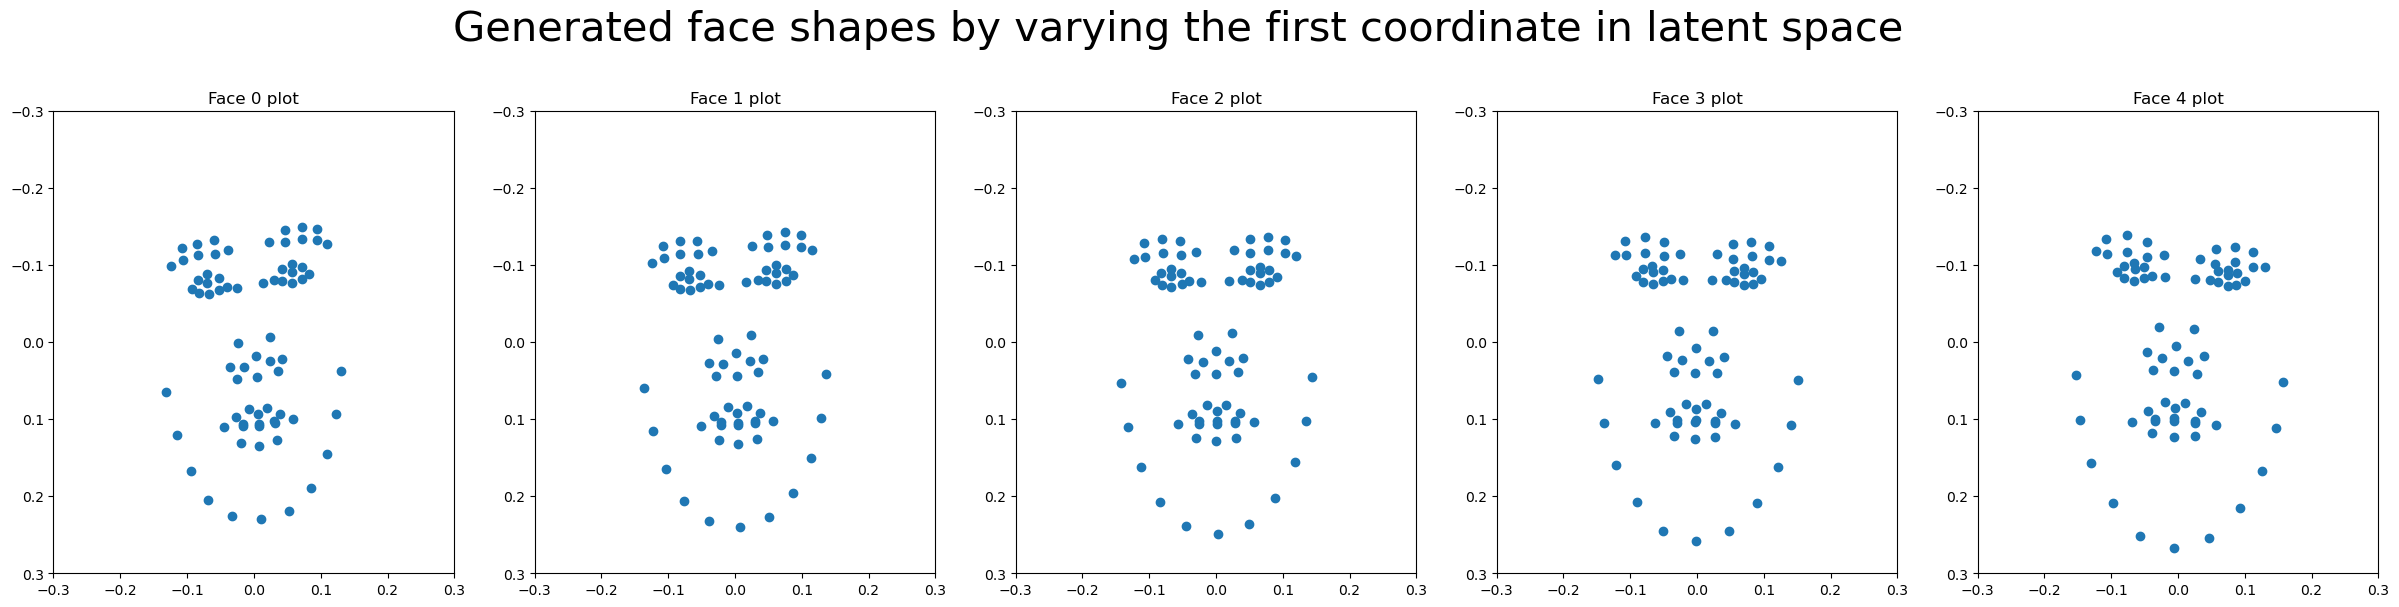

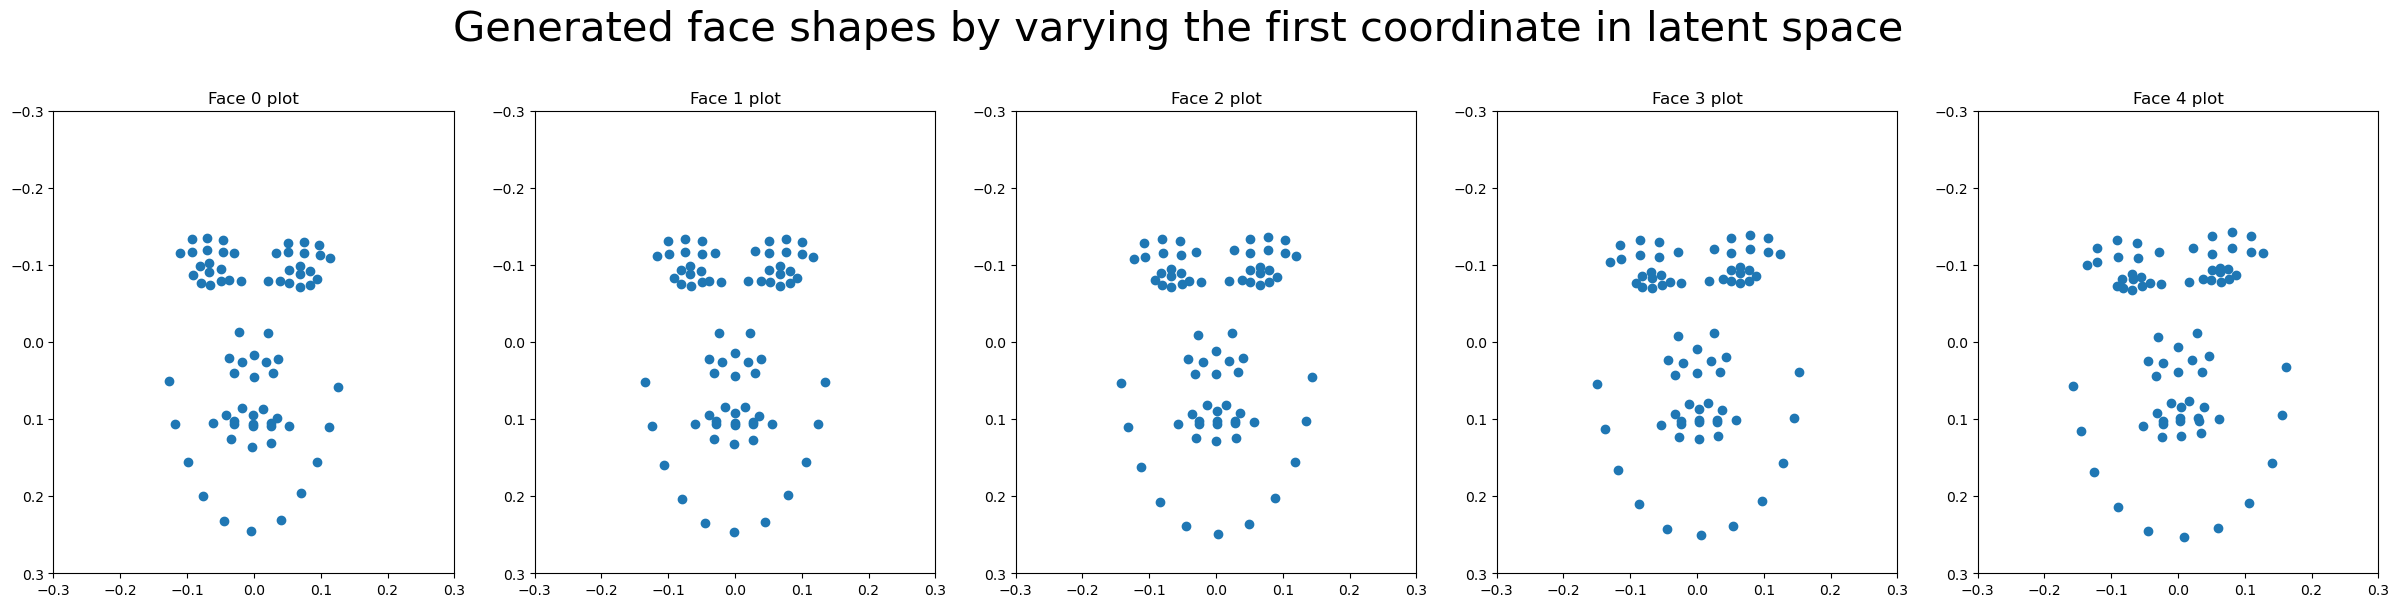

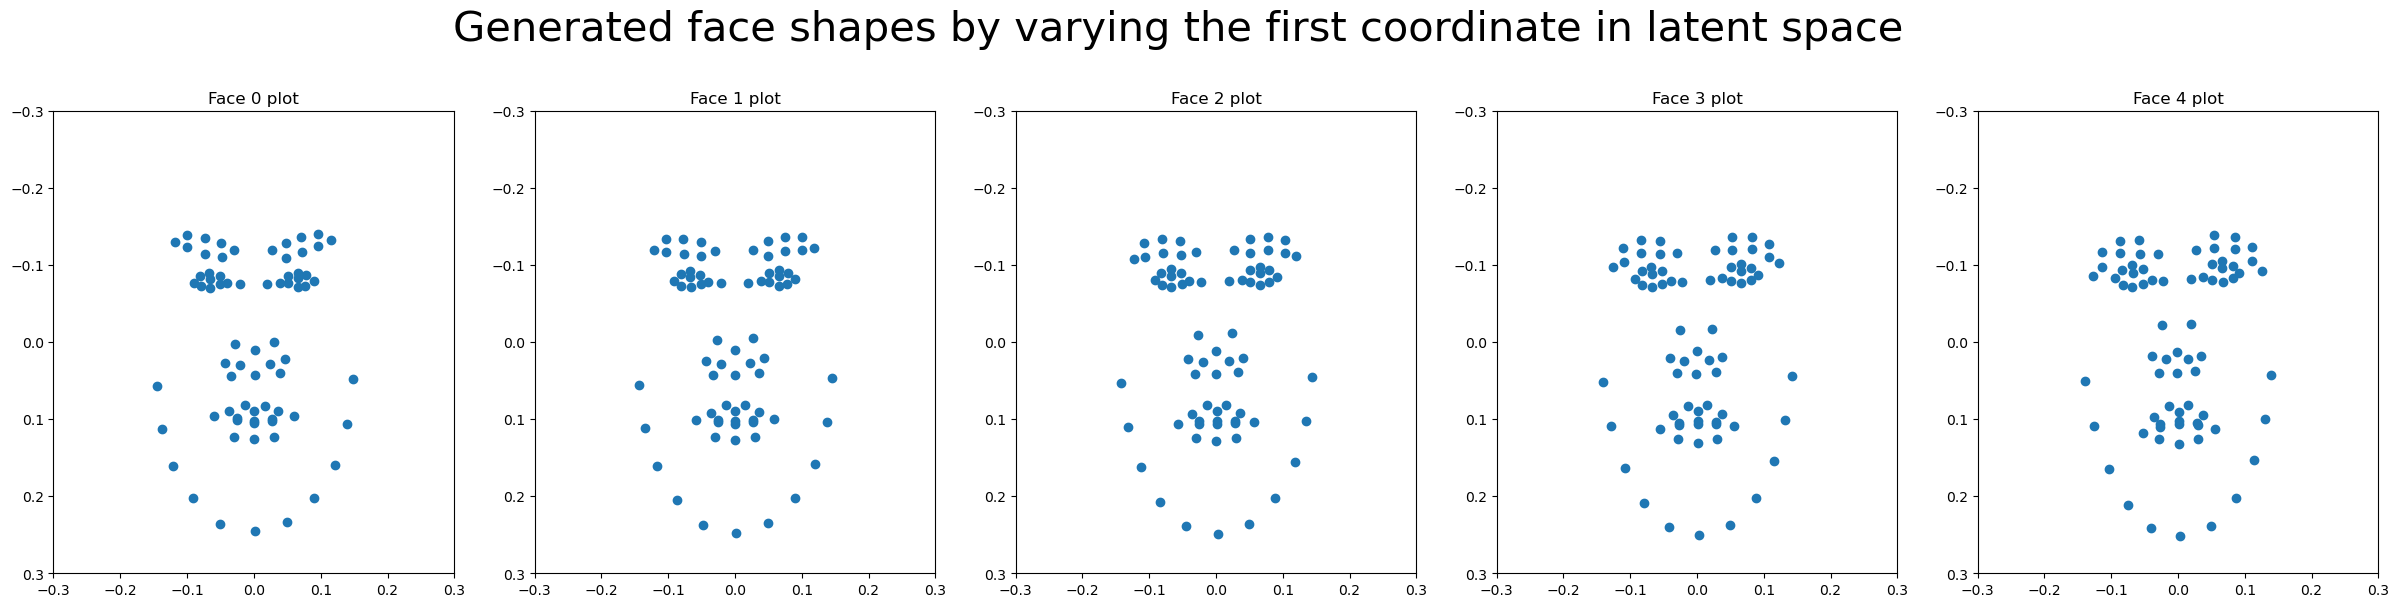

In [17]:
#Tale om. Hvor meget skal plottes???
for component_index  in range(n_components):
    faces = []
    standard_deviation = np.sqrt(val[component_index])
    deviation_matrix = np.zeros((n_components, 5))
    deviation_matrix[:, component_index ] = np.linspace(-3*standard_deviation, 3*standard_deviation, num=5)
    gen_shapes = transform_from_latent_space(deviation_matrix, used, mu)
    plot_many_faces(gen_shapes,"Generated face shapes by varying the first coordinate in latent space")


In [18]:
# Write your reflections here

## Interpolating between shapes
The following example shows how to interpolate two vectors.


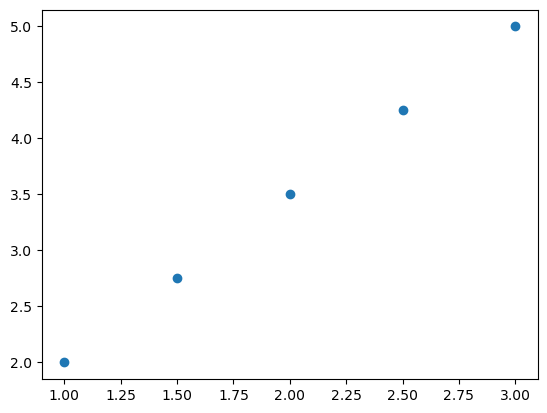

In [19]:
# #Template for doing interpolation between two (2D)- points 
d = np.linspace(np.array([1, 2]), np.array([3, 5]), num=5)
plt.scatter(d[:, 0], d[:, 1])


---
**Task 6 (medium): Interpolation between two faces👩‍💻**
**Shape Interpolation:**
1. Select points $\mathbf{a}$ and $\mathbf{b}$ in latent space (paying attention to the Gaussian constraints) and generate the faces.
2. Use `np.linspace`
 to generate 6 evenly spaced points that interpolate between two vectors, $\mathbf{a}$ and $\mathbf{b}$, in the latent space. Plot the resulting faces. 
3. Select $\mathbf{a}$ and $\mathbf{b}$ such that:    - $\mathbf{a}$ = $[-3\lambda_1,0,-3\lambda_3,0,0]$ and $\mathbf{b}$ = $[3\lambda_1,0,3\lambda_3,0,0]$.
    - $\mathbf{a}$ = $[0,5\lambda_2,0,0,0]$ and $\mathbf{b}$ = $[0,-5\lambda_2,0,0,0]$.
    - the generated shapes represent a smile.




---

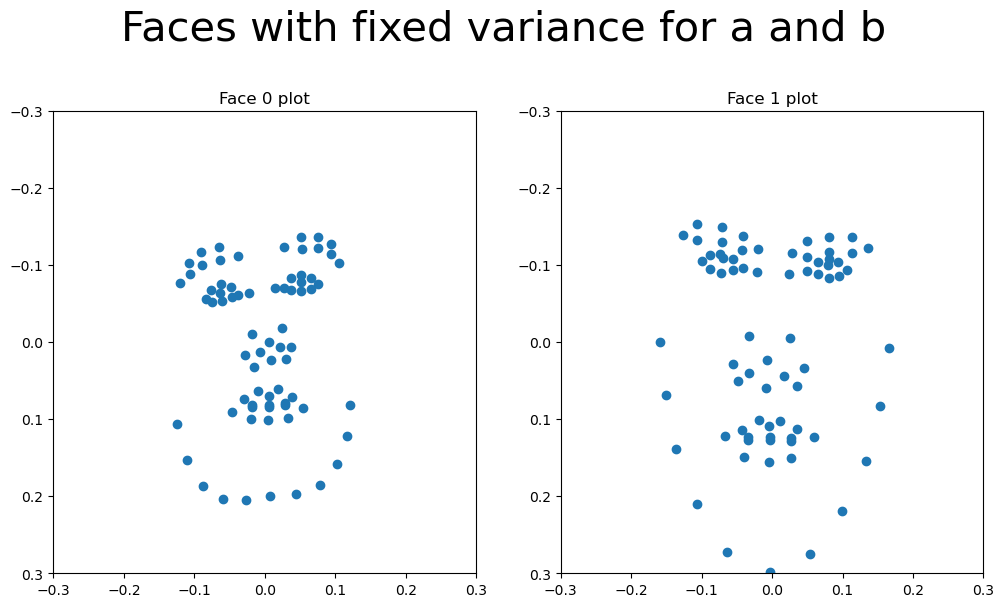

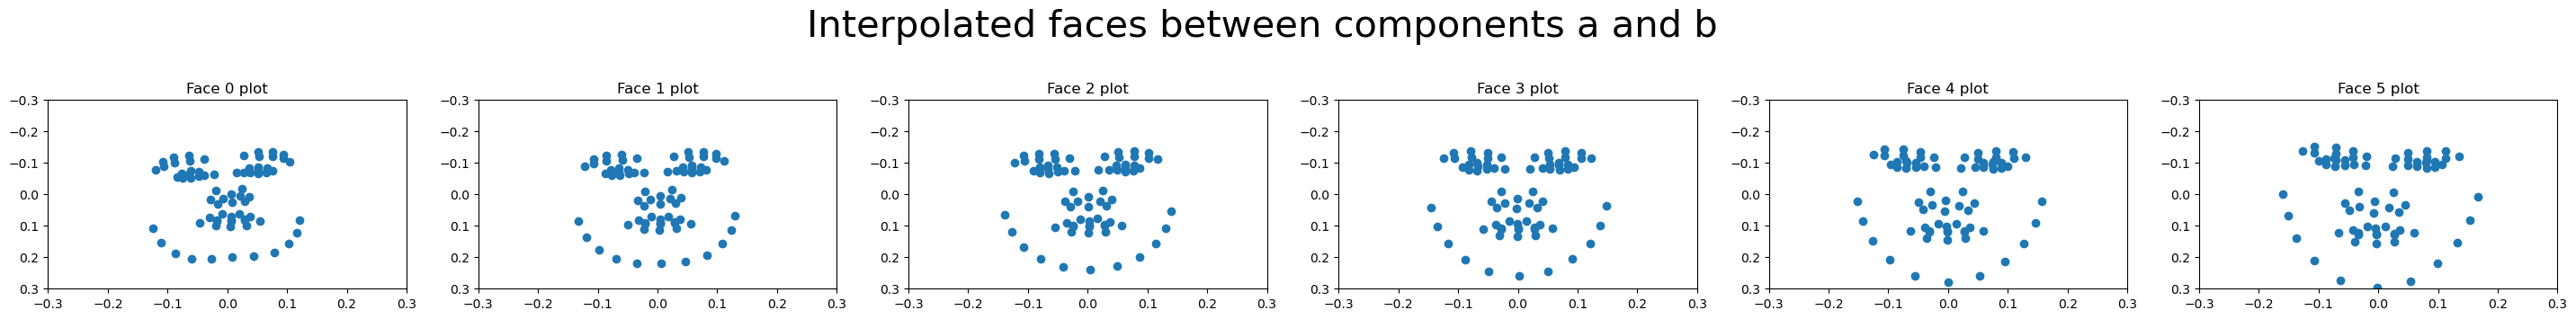

In [22]:
#1
a = np.array([-3 * np.sqrt(val[0]), 0, -3 * np.sqrt(val[2]), 0, 0])
b = np.array([3 * np.sqrt(val[0]), 0, 3 * np.sqrt(val[2]), 0, 0])
face_a = transform_from_latent_space(a, used, mu)
face_b = transform_from_latent_space(b, used, mu)
plot_many_faces([face_a,face_b], "Faces with fixed variance for a and b")

#2
variance_interpol = np.linspace(a,b, num=6)
faces_interpol =[transform_from_latent_space(interp, used, mu) for interp in variance_interpol]
plot_many_faces(faces_interpol, "Interpolated faces between components a and b")


---
**Task 7 (medium): Reflection💡**
Describe and reflect on the results obtained from this assignment, the exercises and the in-class exercises. Answer the following questions:
1. **Behaviour:** Explain why, a set of points interpolated on a line in latent space corresponds to a sample on a line in data space using $x = \Phi\mathbf{a} + \mu$. 
2. How well can a few principal components reproduce the samples? What happens with the generated data when the number of components $k$ is changed to 1,3,9, or 15?


---

In [0]:
# Write reflections here.

## Last section - optional
This final section includes three tasks that offer valuable insights into the application of PCA, however completing this section is optional.

---
**Task 8 (medium): Eigenvalues and eigenvectors of correlation matrix _(optional)_👩‍💻💡**
1. Implement the function `get_principal_components_correlation`
 according to the comments in the cell below.
2. Use the provided code to display the eigenvalues of the correlation matrix.
3. How do the eigenvalues obtained from the covariance matrix compare to those from the correlation matrix in terms of magnitude and the variance each principal component explains? What does this reveal about the effect of feature scaling on PCA results?


---

In [0]:
def get_principal_components_correlation(X):
    """Calculates principal components using the correlation matrix for X.

    Args:
        X: The dataset. An NxD array where N are the number of samples and D are
        the number of features.

    Returns:
        Tuple (components, eigenvalues, mu) where components is a DxD matrix of
        principal components, eigenvalues is a D-element vector of
        corresponding eigenvalues, and mu is a D-element array containing the mean
        vector.
    """
    # Standardize the data
    
    # Compute the correlation matrix
    
    # Sort the eigenvalues and eigenvectors in descending order
    
    return ....

# Use the function on the shapes data
eigenvectors_corr, eigenvalues_corr, mu_corr = get_principal_components_correlation(shapes)

# Optionally, plot the eigenvalues to see their distribution
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues_corr) + 1), eigenvalues_corr, 'o-', linewidth=2)
plt.title('Eigenvalues of the Correlation Matrix')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

variance_explained = eigenvalues_corr / np.sum(eigenvalues_corr)
cumulative_variance_explained = np.cumsum(variance_explained)

# Plot cumulative variance explained
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_explained) + 1),
         cumulative_variance_explained, 'o-', linewidth=2)
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.axhline(y=0.95, color='r', linestyle='--')  # Line to indicate 90% variance
plt.grid(True)
plt.show()


---
**Task 9 (medium): Dimensionality reduction of features _(optional)_👩‍💻💡**
1. **Transform data:** Use $\mathbf{\Phi^{\top}}$​ to transform the data $\mathbf{x}$ into its latent-space representation $\mathbf{x'}$ (using $\mathbf{x'}= \mathbf{\Phi^{\top}}(\mathbf{x}-\mathbf{\mu})$).
2. Plot the first two  components in latent space using a scatterplot.    - What does this plot tell you about the distribution of faces?
    - Try plotting different pairs of components. Describe how each combination separates (clusters) the dataset differently.


3. **Interpolate between real faces:** Re-implement [Task 6](#interpolate) but instead of selecting 2 points in latent space, transform two real faces to latent space and interpolate between them.     - Plot the faces of the interpolated points.




---

In [0]:
# Write implementation here

Describe the different scatter plots of component combinations

---
**Task 10 (medium): Out of distribution generation _(optional)_👩‍💻💡**
1. **Extreme values:** What happens if you select values outside the suggested range. Explain why this happens.


---

In [0]:
# Write implementation and reflections here